## 02. Neural Network Classification in PyTorch

### 0.  Architecture

- input layer shape -> in_features
- hidden layer(s)
- neurons per hidden layer -> generally 10 to 512
- output layer shape -> out_features
- hidden layer activation -> usually ReLU
- output activation -> usually Sigmoid / Softmax
- loss function -> (binary) cross entropy (torch.nn.BCELoss / torch.nn.CrossEntropyLoss)
- optimizer -> SGD/Adam

### 1. Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [3]:
# make dataframe of circle data
import pandas as pd

circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


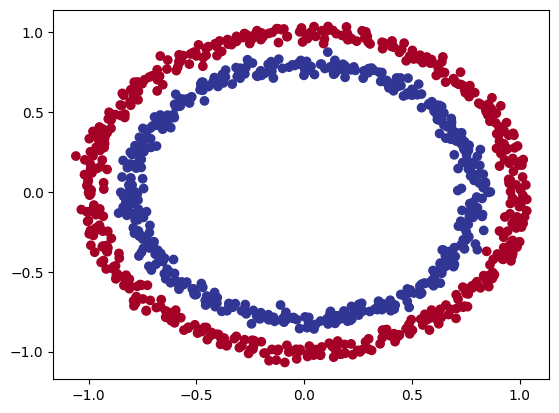

In [4]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu)

**Find out how we could build a PyTorch neural network to classify dots into red (0) or blue (1).**

`Note:` this dataset is often referred to as a `toy dataset` -> small enough to experiment but still sizeable to practice the fundamentals

### 1.1 Check input and output shapes

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print("Values for one sample of X:", X_sample, " and for y:", y_sample)
print("Shape for one sample of X:", X_sample.shape, " and for y:", y_sample.shape)

Values for one sample of X: [0.75424625 0.23148074]  and for y: 1
Shape for one sample of X: (2,)  and for y: ()


### 1.2 Turn data into Tensors and Split train and test set

In [7]:
# turn into tensors
import torch

torch.__version__

'2.1.0.dev20230709'

In [8]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [9]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [10]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [11]:
# split data into training and testing dataset
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size= 0.2,
                                                   random_state=42)

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### 2. Build the model

Build the model to classify blue and red dots:
- (1) setup device agonistic code -> run on GPU if available
- (2) construct a model (2 `nn.Linear` layers)
- (3) define a loss and optimizer
- (4) create a training and testing loop

In [13]:
import torch
from torch import nn

device = "mps" if getattr(torch, 'has_mps', False) \
    else "gpu" if torch.cuda.is_available() else "cpu"
device

/var/folders/df/mx2gggdn7p55_8g8_fxxk8zc0000gn/T/ipykernel_89823/3865436524.py:4: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = "mps" if getattr(torch, 'has_mps', False) \


'mps'

In [14]:
# create a model class
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        # create 2 nn.linear layers
        # takes in 2 features and upscale to 5 features -> 5 hidden layers
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        # takes in 5 features from previous layer and outputs a single feature
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

        """
        self.two_linear_layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=5),
            nn.Linear(in_features=5, out_features=1)
        )
        """

    def forward(self, x):
        # x -> layer_1 -> layer_2 -> output
        return self.layer_1(self.layer_2(x))

        """ return self.two_linear_layers(x) """

- tensorflow playground - a visual example of what a similar classificiation neural network looks like
- figma

In [15]:
# inatantiate an instance
model_0 = CircleModelV0().to(device)
model_0, next(model_0.parameters()).device

(CircleModelV0(
   (layer_1): Linear(in_features=2, out_features=5, bias=True)
   (layer_2): Linear(in_features=5, out_features=1, bias=True)
 ),
 device(type='mps', index=0))

In [16]:
# replicate using `nn.Sequential()`

# performs a forward pass computation of the input data through the layers in
# the order they appear
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
print('model parameters before training:')
model_0.state_dict()

model parameters before training:


/Users/wzy/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/_tensor_str.py:137: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:248.)
  nonzero_finite_vals = torch.masked_select(


OrderedDict([('0.weight',
              tensor([[-0.5948, -0.3050],
                      [-0.6417,  0.2946],
                      [ 0.1043,  0.1597],
                      [-0.1505, -0.2174],
                      [-0.1062,  0.6072]], device='mps:0')),
             ('0.bias',
              tensor([-0.1520,  0.1448,  0.3181, -0.2083,  0.5611], device='mps:0')),
             ('1.weight',
              tensor([[-0.0016, -0.0788,  0.4265, -0.2886,  0.3429]], device='mps:0')),
             ('1.bias', tensor([-0.3458], device='mps:0'))])

In [18]:
# make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print("Length of predictions:", len(untrained_preds), ", shape:", untrained_preds.shape)
print("Length of test samples:", len(y_test), "Shape:", y_test.shape)
print("\nFirst 10 predictions:\n", torch.round(untrained_preds[:10]))
print("\nFirst 10 test labels:\n", y_test[:10])


Length of predictions: 200 , shape: torch.Size([200, 1])
Length of test samples: 200 Shape: torch.Size([200])

First 10 predictions:
 tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='mps:0')

First 10 test labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

-> problem specific

**PyTorch binary cross entropy:**
- `torch.nn.BCELoss():` Creates a loss function that measures the binary cross entropy between the target (label) and input (features)
- `torch.nn.BCEWithLogitsLoss():` the same as above except it has a sigmoid layer (`nn.Sigmoid`) built-in


=> logits in deep learning: https://saturncloud.io/blog/what-is-the-meaning-of-the-word-logits-in-tensorflow/

In [19]:
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in

"""
nn.Sequential(
    nn.Sigmoid(),
    nn.BCELoss()
)   # similar to nn.BCEWithLogitsLoss()
"""

loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [20]:
# create accuracy metrics
def accuracy_fn(y_true, y_pred):
    # torch.eq() calculates where two tensors are equal
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

### 3. Train model

### 3.1 Goingfrom raw logits -> prediction probabilities -> prediction labe;s

The model outputs are going to be `raw logits`.

Can convert these `logits` into prediction probabilities by passing them to `activation function`.
e.g. sogmoid/softmax.

Then, convert model's prediction probabilities to `prediction labels` by either **rounding** or taking the **argmax()**.

`Note: '.eval()'` -> a kind of switch for some specific layers/parts of the model that behave differently during training and inference (evaluating) time

In [21]:
# view the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.2085],
        [ 0.3365],
        [-0.1408],
        [ 0.3075],
        [-0.1626]], device='mps:0')

In [22]:
# use sigmoid activation function on model logits -> turn into prediction probability
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5519],
        [0.5833],
        [0.4649],
        [0.5763],
        [0.4594]], device='mps:0')

In [23]:
# pass to round function to get prediction labels
y_preds = torch.round(y_pred_probs)

# in full:
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='mps:0')


tensor([1., 1., 0., 1., 0.], device='mps:0')

### 3.2 Build training and testing loop

In [24]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 100

for epoch in range(epochs):
    ### Training
    model_0.train()

    # forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # calculate the loss/accuracy
    # nn.BCEWithLogitsLoss() -> expect raw logits as input
    # nn.BCELoss() -> expect prediction probabilities as input
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # zero the optimizer
    optimizer.zero_grad()
    # backpropagattion
    loss.backward()
    # GD
    optimizer.step()

    # testing code
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        t_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if (epoch % 10 == 0):
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Acc: {acc:.2f} | Test loss: {t_loss:.5f} | Test Acc: {test_acc:.2f}%")


Epoch: 0 | Train Loss: 0.69689 | Acc: 51.38 | Test loss: 0.70688 | Test Acc: 47.50%
Epoch: 10 | Train Loss: 0.69607 | Acc: 51.12 | Test loss: 0.70512 | Test Acc: 47.00%
Epoch: 20 | Train Loss: 0.69553 | Acc: 50.88 | Test loss: 0.70383 | Test Acc: 46.50%
Epoch: 30 | Train Loss: 0.69512 | Acc: 51.50 | Test loss: 0.70282 | Test Acc: 46.00%
Epoch: 40 | Train Loss: 0.69480 | Acc: 51.12 | Test loss: 0.70199 | Test Acc: 46.00%
Epoch: 50 | Train Loss: 0.69454 | Acc: 51.00 | Test loss: 0.70128 | Test Acc: 45.00%
Epoch: 60 | Train Loss: 0.69432 | Acc: 51.25 | Test loss: 0.70067 | Test Acc: 45.00%
Epoch: 70 | Train Loss: 0.69413 | Acc: 51.25 | Test loss: 0.70013 | Test Acc: 45.00%
Epoch: 80 | Train Loss: 0.69397 | Acc: 51.25 | Test loss: 0.69965 | Test Acc: 45.00%
Epoch: 90 | Train Loss: 0.69383 | Acc: 51.25 | Test loss: 0.69923 | Test Acc: 45.00%


### 4. Make predictions and evaluate the model

looks like didn't learn anything...

-> import a function called `plot_decision_boundary()`

In [25]:
# make some presiction and visualize them
import requests
from pathlib import Path

# download helper function
if Path("helper_function.py").is_file():
    print("file already exists, skipping download.")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


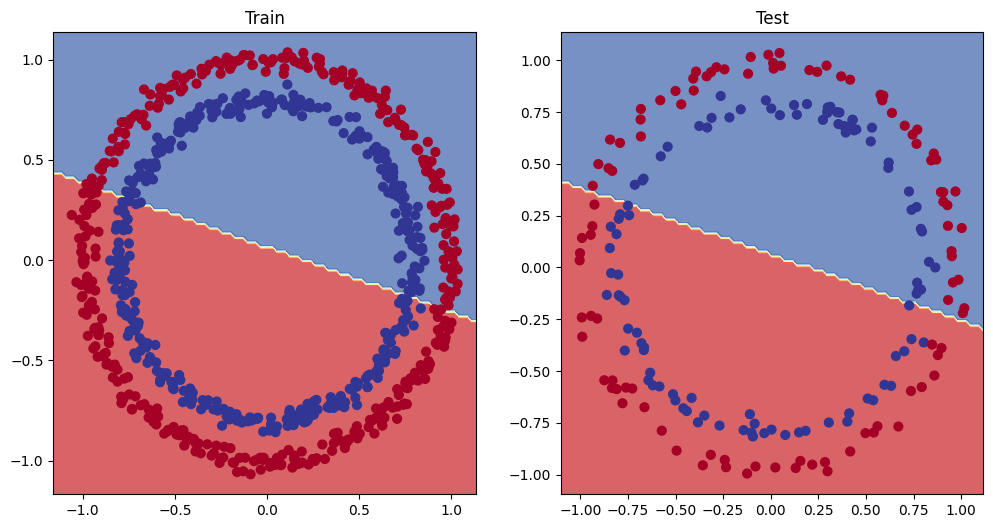

In [26]:
# plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)